# Hands-On Regression
***

In this notebook we'll investigate Scikit-Learn's functionality for performing ordinary and polynomial regression.  In addition, we'll look at how we can chain together things like feature transformations with estimators to build powerful machine learning pipelines.  Finally, we'll see how we can validate the performance of our regression models by doing regularization studies and plotting learning curves. 

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and execute those cells before continuing. 

In [39]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### Part 1: Data Examination and Visualization
***

The data we will explore in this notebook relates the change in the water level in a damn to the rate of flow of water through the damn. First we'll load the data which is stored in a serialized format in the data directory.  We'll store the features in a 2D Numpy array $X$ and the response in a 1D Numpy array $y$. 

In [40]:
import pickle
with open("data/dam_regression.pickle", "rb") as fname: dam_data = pickle.load(fname)
X = dam_data["features"]
y = dam_data["response"]

**Part A**: How many examples are in the data set?  How many features does each example have? 

In [41]:
n_examples = len(y)
n_features = X.shape[1]
print("There are {:2d} examples in the data set".format(n_examples))
print("Each example contains {:d} feature(s)".format(n_features))

There are 54 examples in the data set
Each example contains 1 feature(s)


**Part B**: Next we'll look at the data by making a scatter plot.  The following function (found at the bottom of this notebook) will do all of the plotting for you. 

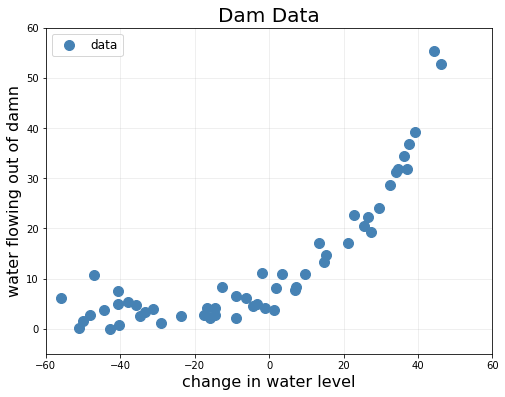

In [42]:
dam_plot([(X, y, "data")])

**Part C**: How would you characterize relationship between the feature $X$ and the response $y$? Is the relationship linear?  Is it nonlinear?  Is it highly nonlinear? 

It's definitely nonlinear.  But it looks like the nonlinearity is fairly mild. 

### Part 2: Building Our First Simple Model 
***

In this section we'll use Scikit-Learn to build a simple linear regression model for our data. As usual, the first step in our process will be to divide the data into a training and a validation set.  Scikit-learn has a handy function to do this for us called [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Clicking the link will take you to the documentation.  You'll see in the documentation that the function takes in the complete data matrix and response vector, as well as a specification of the fraction of data to go in the training set.  Finally, it takes a `random_state` value that sets the seed of the random number generator.  We'll specify a random state so that everyone's data looks the same.   

In [43]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=1734)

**Part A**: We selected a split with $80\%$ and $20\%$ of the data split into the training set and validation set, respectively.  How many examples are in each set? 

In [44]:
print("The training set has {:d} examples and the validation set has {:d} examples".format(len(y_train), len(y_valid)))

The training set has 43 examples and the validation set has 11 examples


**Part B**: Let's plot the resulting training and validation sets in different colors so we can see what's what. 

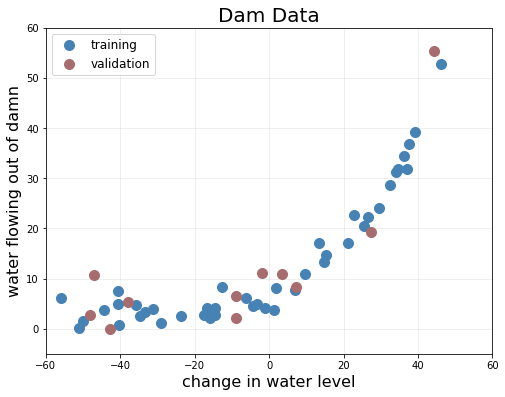

In [45]:
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")])

**Part C**: Next we'll build a linear regression model to fit the data. Anticipating that we may want to do regularization at a later time, we'll use Scikit-Learn's [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class. Use the link to check out the documentation. 

Notice that the class can be instantiated with several parameters, including a regularization parameter `alpha` (which is what we, and the rest of the civilized world, call $\lambda$).  Additionally, the class contains flags indicating whether or not to fit an intercept (or bias) term and whether or not to normalize the data before fitting.  We'll leave the parameters as is (yes to fitting a bias term and no to normalizing). We'll also start out with `alpha` ($\lambda$) set equal to zero, so we're really doing standard linear regression. 

In [46]:
from sklearn.linear_model import Ridge
linreg = Ridge(alpha=0) 

So far we've only created an instance of the class.  Next we need to fit the model to our data.  Almost all models in Scikit-Learn come with a `.fit` method used to train the model.  We need to pass in the training features in `X_train` and the training responses in `y_train`. 

In [47]:
linreg.fit(X_train, y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

**Part D**: Congratulations! You've just trained your first machine learning model using Scikit-Learn.  But how successful were we?  One way we might check is by looking at the MSE on the training data and on the validation data. In order to compute the MSE we first need to compute the predictions of the model on the training data and the validation data. We can do this using the `predict` method and passing in the training features and the validation features stored in `X_train` and `X_valid`.  

In [48]:
yhat_train = linreg.predict(X_train)
yhat_valid = linreg.predict(X_valid)

Finally, we can use the `mean_square_error` method to compute the MSE of the predictions.  

In [49]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(yhat_train, y_train)
mse_valid = mean_squared_error(yhat_valid, y_valid)

print("Training MSE:   {:.3f}".format(mse_train))
print("Validation MSE: {:.3f}".format(mse_valid))

Training MSE:   45.296
Validation MSE: 100.367


**Part E**: The MSE is a relatively simple calculation that potentially doesn't warrant a call to an sklearn function.  Can you verify these values by computing them directly in Numpy? Remember that the formula for MSE is given by 

$$
MSE = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y}_i\right)^2
$$

In [50]:
my_mse_train = np.mean((y_train - linreg.predict(X_train))**2) #TODO 
my_mse_valid = np.mean((y_valid - linreg.predict(X_valid))**2) #TODO 
print("Training MSE:   {:.3f}".format(my_mse_train))
print("Validation MSE: {:.3f}".format(my_mse_valid))

Training MSE:   45.296
Validation MSE: 100.367


**Part F**: Finally, let's plot our linear model against our training and validation data.  Like most plotting libraries, Matplotlib takes in an arrays of $x$-values and $y$-values and simply connects the dots.  In order to generate some plotting data, one thing we could do is create an array of equispaced $x$-values an then use our model prediction to get an array of $y$-values.  Fill in the missing code below to accomplish this. 

**Note**: The quirky `.reshape(-1,1)` call below turns the 1D array that `linespace` returns into a 2D array.  Pretty uniformly across Scikit-Learn classes, the `fit` and `predict` methods expect your features to be a 2D array.  Learn this quirk now to avoid many painful `DeprecationWarning`'s in the future. 

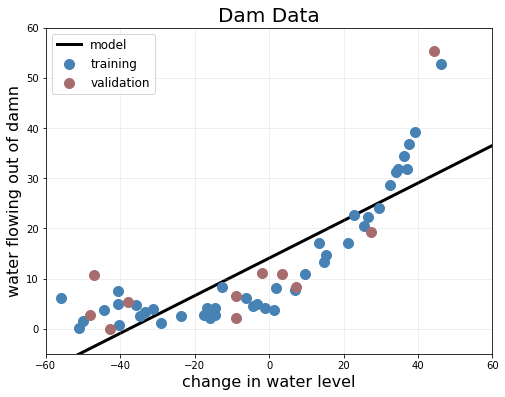

In [51]:
xplot = np.linspace(-60,60,100).reshape(-1,1)
yplot = linreg.predict(xplot) #TODO 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

As expected, the linear model does not seem to fit the data particularly well.  Let's see if we can improve this with a polynomial model. 

### Part 3: Building a Polynomial Regression Model in Scikit-Learn 
***

Recall that Polynomial Regression is just multiple linear regression where we create new features that are powers of our original single feature.  In other words, our single feature $X$ turns into multiple features as 

$$
    X \quad \mapsto \quad X_1 = X, \quad X_2 = X^2, \quad X_3 = X^3 ,\quad \ldots,\quad X_p = X^p 
$$

We could create a new Numpy array where each column is a power of our original feature $X$, but Scikit-Learn can do this much more efficiently using the [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class. We'll demonstrate it's functionality first on a very simple example and then apply it to our data.

In [52]:
from sklearn.preprocessing import PolynomialFeatures

Z = np.array([[1], [2], [3]])
print(Z)

[[1]
 [2]
 [3]]


Note that `Z` is just a 2D Numpy array with $1$, $2$, and $3$ as the entries in it's sole column.  Next we'll create an instance of PolynomialFeatures that augments `Z` with polynomial features up to degree 3. 

In [53]:
cubic_features = PolynomialFeatures(degree=3, include_bias=False)
Zp = cubic_features.fit_transform(Z)
print(Zp)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]]


You can see that the resulting `Zp` array includes the square and cubes of the original vector as new columns.  Note that if you change the `include_bias` flag to `True` it will prepend a column of ones, making our new matrix a regression design matrix.  We will skip this though because most regression classes in Scikit-Learn will do this for us internally (this is the `fit_intercept=True` flag in `Ridge` described previously). 

**Part A**: OK, time to fit our polynomial regression model.  We'll do this by transforming our training set into a matrix of polynomial features, and then fitting a model using the `Ridge` class. For now, we'll start with a degree $3$ polynomial.  

In [54]:
degree =3 
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
Xp_train = poly_features.fit_transform(X_train)
polyreg = Ridge(alpha=0)
polyreg.fit(Xp_train, y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

**Part B**: Let's use our new model to make predictions on the training set and the validation set and computing the resulting MSEs. Note that our Polynomial Regression model expects a matrix of polynomial features, thus we have to transform our validation set features as well.  After that we'll make a plot of the resulting polynomial model. 

In [55]:
Xp_valid = poly_features.transform(X_valid)
yphat_train = polyreg.predict(Xp_train)
yphat_valid = polyreg.predict(Xp_valid)
print("Degree {:d} Train MSE:      {:.3f}".format(degree, mean_squared_error(yphat_train, y_train)))
print("Degree {:d} Validation MSE: {:.3f}".format(degree, mean_squared_error(yphat_valid, y_valid)))

Degree 3 Train MSE:      3.776
Degree 3 Validation MSE: 19.276


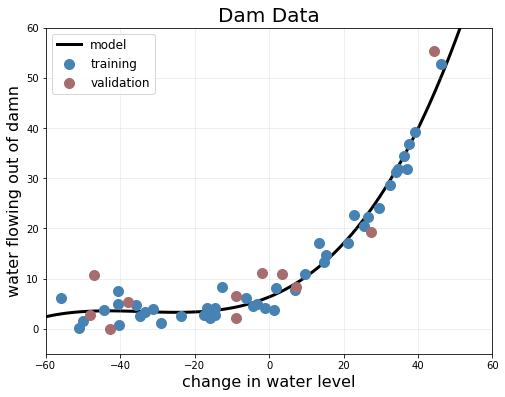

In [56]:
xplot = np.linspace(-60,60,100).reshape(-1,1)
xpplot = poly_features.transform(xplot)
yplot = polyreg.predict(xpplot) 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

**Part C**: Hey!  That looks pretty good! Notice that in addition to an aesthetically pleasing fit, both our training and validation errors went down.  

But we know good things never last ... let's break it.  Go back to the previous part and increment the polynomial degree until the model starts overfitting. 

### Part 4: Building a Ridge Regression Pipeline in Scikit-Learn 
***

OK, so our implementation of a polynomial regression model above had a lot of moving parts.  We had to transform both our training and validation data to include polynomial features and then fit a regression model.  Eventually we'll add more bells and whistles to our model as well.  At this point, it's a good idea to talk about how to consolidate this process into a single command using Scikit-Learn's [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class.  

The general idea is that we'll include all of our transformations and models into a pipeline so we can perform a single call to fit and predict to do the magic.  

**Part A**: Here is how you build a pipeline to generate polynomial features and then fit a regression model at the same time.  Note that you've seen all of these routines before, we're just combining them into one. 


In [57]:
from sklearn.pipeline import Pipeline

degree, alpha = 3, 0
polyregcombo = [("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                ("ridge", Ridge(alpha=alpha))]
polyregpipe = Pipeline(polyregcombo)

Now when we call things like `.fit` and `.predict` on our pipeline object, it knows to perform the `.fit` and `.predict` methods for each of the constituents parts in sequence.  Let's try it. Notice that the output after calling `.fit` gives you a nice summary of all of the methods and parameters in your pipeline. 

In [58]:
polyregpipe.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)), ('ridge', Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Finally, we'll use our pipeline to make predictions, check MSEs, and produce a plot.  The workflow will pretty much the same as before, but we've consolidated all of the individual calls to the tranformers and model into the pipeline. 

Degree 3 Train MSE:      3.776
Degree 3 Validation MSE: 19.276


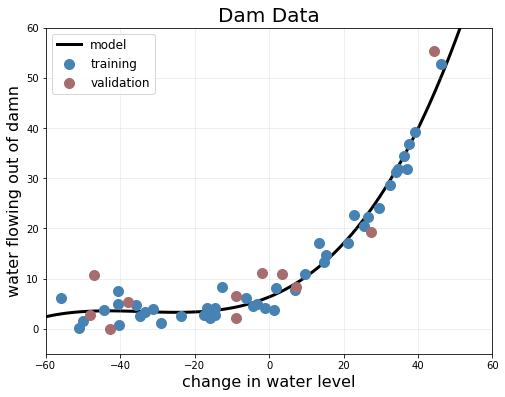

In [59]:
yphat_train = polyregpipe.predict(X_train)
yphat_valid = polyregpipe.predict(X_valid)
print("Degree {:d} Train MSE:      {:.3f}".format(degree, mean_squared_error(yphat_train, y_train)))
print("Degree {:d} Validation MSE: {:.3f}".format(degree, mean_squared_error(yphat_valid, y_valid)))

xplot = np.linspace(-60,60,100).reshape(-1,1)
yplot = polyregpipe.predict(xplot) 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

**Part B**: The last thing we'll do is add standardization of features to our pipeline.  Recall that before doing regularization it's always a good idea to mean-center your features and scale them so that they have standard deviation of $1$.  We can do this with a feature transformer called the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). We'll plug this into our pipeline in between the polynomial feature generation and the call to `Ridge`. 

In [60]:
from sklearn.preprocessing import StandardScaler

degree, alpha = 3, 0
stand_combo = [("poly", PolynomialFeatures(degree=degree, include_bias=False)),
               ("stand", StandardScaler()),
               ("ridge", Ridge(alpha=alpha))]
polystandpipe = Pipeline(stand_combo)

Finally, we'll refit the data and generate MSEs and plots using the new pipeline.  Since we have `alpha=0` set, we're still doing vanilla linear regression, and expect to obtain the same results. 

Degree 3 Train MSE:      3.776
Degree 3 Validation MSE: 19.276


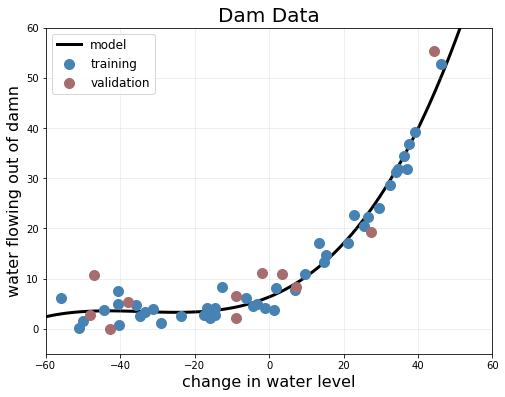

In [61]:
polystandpipe.fit(X_train, y_train)
yphat_train = polystandpipe.predict(X_train)
yphat_valid = polystandpipe.predict(X_valid)
print("Degree {:d} Train MSE:      {:.3f}".format(degree, mean_squared_error(yphat_train, y_train)))
print("Degree {:d} Validation MSE: {:.3f}".format(degree, mean_squared_error(yphat_valid, y_valid)))

xplot = np.linspace(-60,60,100).reshape(-1,1)
yplot = polystandpipe.predict(xplot) 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

**Part C**: Let's see how we can systematically zero in on a good regularization parameter for the degree $12$ model. Typically what we'd do is run our model for many values of the regularization parameter and examine the MSE on the training and validation sets.  The optimal regularization parameter is then the place on the curve with the lowest validation error.  Scikit-Learn implements this functionality using something called a [validation_curve](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve). 

**Note**: When `validation_curve` loops over parameters in your model, it doesn't change them back at the end.  Since we're going to use this bad model again later, I have reset `alpha` to zero after making the validation curve plot. 

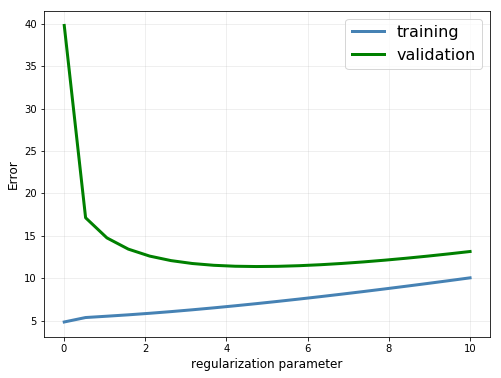

In [62]:
from sklearn.model_selection import validation_curve

lams = np.linspace(0.01, 10, 20)

# overwrite old feature transformation with desired degree
degree=12
polystandpipe.set_params(poly__degree=degree)

neg_MSE_train_folds, neg_MSE_valid_folds = validation_curve(polystandpipe, X, y, 
                                                            param_name="ridge__alpha", param_range=lams,
                                                            cv=5, scoring="neg_mean_squared_error")

MSE_train = -np.mean(neg_MSE_train_folds, axis=1)
MSE_valid = -np.mean(neg_MSE_valid_folds, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(lams, MSE_train, lw=3, color="steelblue", label="training")
ax.plot(lams, MSE_valid, lw=3, color="green", label="validation")
ax.grid(alpha=0.25)
ax.set_xlabel("regularization parameter", fontsize=12)
ax.set_ylabel("Error", fontsize=12)
ax.legend(loc="upper right", fontsize=16);

# Reset alpha=0 in polystandpipe
polystandpipe.set_params(ridge__alpha=0);

**Part C**: Eyeball (or compute exactly, if you can) the optimal value of the regularization strength.  Then create a new regularized model using the desired value of $\lambda$, check MSE, make plots, etc. 

Degree 12 Train MSE:      5.307
Degree 12 Validation MSE: 16.717


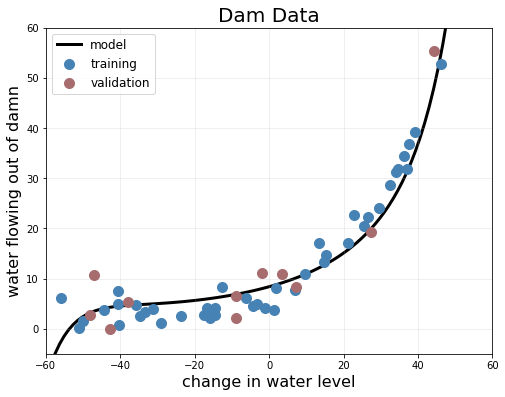

In [63]:
degree, alpha = 12, 5
reg_combo= [("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("stand", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))]
regstandpipe = Pipeline(reg_combo)

regstandpipe.fit(X_train, y_train)
yphat_train = regstandpipe.predict(X_train)
yphat_valid = regstandpipe.predict(X_valid)
print("Degree {:d} Train MSE:      {:.3f}".format(degree, mean_squared_error(yphat_train, y_train)))
print("Degree {:d} Validation MSE: {:.3f}".format(degree, mean_squared_error(yphat_valid, y_valid)))

xplot = np.linspace(-60,60,100).reshape(-1,1)
yplot = polystandpipe.predict(xplot) 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

### Part 5: Evaluating the Bias-Variance using Learning Curves 
***

We've now constructed three different models: a vanilla linear regression model (`linreg`), an unregularized degree $12$ polynomial regression model (`polystandpipe`), and a regularized degree $12$ polynomial regression model (`regstandpipe`).  

**Part A**: What does your intuition tell you with regard to the Bias-Variance Trade-Off of these models.  Does each of them have high or low Bias? Does each of them have high or low variance? 


**Part B**: One way to estimate the bias-variance of a real-life model is by plotting a so-called learning curve.  If there is enough time, I will now show you some slides on the topic.  If not, you can check out the slides at the end of the Bias-Variance Trade-Off lecture, and we'll also talk about learning curves next week.  For now, this is how you plot a learning curve for the `linreg` model in Scikit-Learn. What does the resulting learning curve indicate with respect to bias-variance for the linear model?  

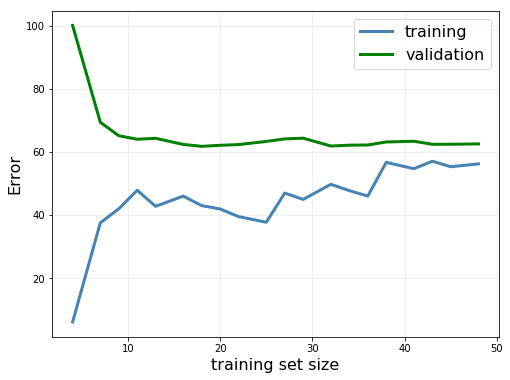

In [64]:
from sklearn.model_selection import learning_curve

train_sizes, neg_MSE_train_folds, neg_MSE_valid_folds = learning_curve(estimator=linreg, X=X, y=y,
                                                        train_sizes=np.linspace(0.1, 1, 20), cv=10,
                                                        scoring="neg_mean_squared_error") 

MSE_train = -np.mean(neg_MSE_train_folds, axis=1)
MSE_valid = -np.mean(neg_MSE_valid_folds, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(train_sizes, MSE_train, lw=3, color="steelblue", label="training")
ax.plot(train_sizes, MSE_valid, lw=3, color="green", label="validation")
ax.grid(alpha=0.25)
ax.set_xlabel("training set size", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.legend(loc="upper right", fontsize=16);

Note that we have a very small gap between the validation and training error, indicating that the model has **low variance**.  Additionally, the training MSE is fairly high, indicating that the model has **high bias**. 

**Part C**: Repeat **Part B** for the unregularized degree 12 model `polystandpipe`. 

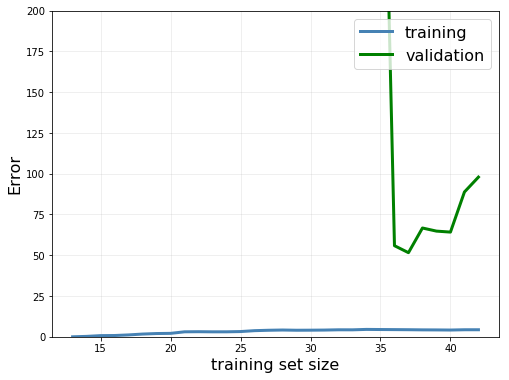

In [65]:
from sklearn.model_selection import learning_curve

# reset alpha to zero (modified by validation_curve)
polystandpipe.set_params()


train_sizes = np.array([13+ii for ii in range(43-13)])
train_sizes, neg_MSE_train_folds, neg_MSE_valid_folds = learning_curve(estimator=polystandpipe, X=X, y=y,
                                                        train_sizes=train_sizes, cv=5,
                                                        scoring="neg_mean_squared_error") 

MSE_train = -np.mean(neg_MSE_train_folds, axis=1)
MSE_valid = -np.mean(neg_MSE_valid_folds, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(train_sizes, MSE_train, lw=3, color="steelblue", label="training")
ax.plot(train_sizes, MSE_valid, lw=3, color="green", label="validation")
ax.grid(alpha=0.25)
ax.set_xlabel("training set size", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.legend(loc="upper right", fontsize=16);
ax.set_ylim([0,200]);

Note that there is now a gigantic gap between the validation and training MSE, indicating that the method has **high variance** (as we would expect, since it's an unregularized high-degree polynomial regression).  Additionally, the training MSE is fairly low, indicating that the model has **low bias**. 

**Part D**: Repeat **Part B** for the regularized degree 12 model `regstandpipe`. 

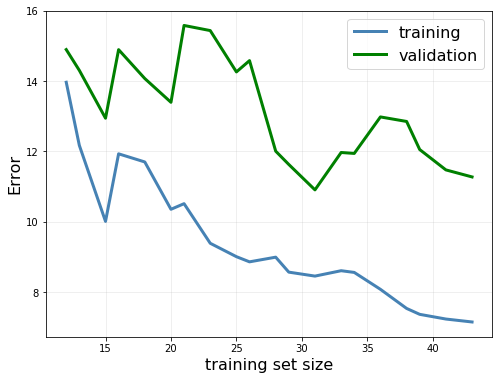

In [66]:
from sklearn.model_selection import learning_curve

train_sizes = np.array([13+ii for ii in range(43-13)])
train_sizes, neg_MSE_train_folds, neg_MSE_valid_folds = learning_curve(estimator=regstandpipe, X=X, y=y,
                                                        train_sizes=np.linspace(.28, 1, 20), cv=5, 
                                                        scoring="neg_mean_squared_error") 

MSE_train = -np.mean(neg_MSE_train_folds, axis=1)
MSE_valid = -np.mean(neg_MSE_valid_folds, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(train_sizes, MSE_train, lw=3, color="steelblue", label="training")
ax.plot(train_sizes, MSE_valid, lw=3, color="green", label="validation")
ax.grid(alpha=0.25)
ax.set_xlabel("training set size", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.legend(loc="upper right", fontsize=16);

Note that with regularization we now have a fairly small gap between the validation and training MSE, indicating that the method has fairly **low variance**.  The training MSE is again pretty low, indicating that the model has fairly **low bias**. Finally, the validation error seems to be on a downward trend.  Indicating that if we could add more data to the training set we might see further improvement! 

**Note**: If you're worried about the fact that the training error starts out high instead of low, remember that this is a regularized model, meaning that the model can't fit small training set sizes exactly like an OLS model would be able to. 

<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>

### Helper Functions
***

In [67]:
def dam_plot(scatter=[], models=[]):
    '''
    Function to plot the dam data 
    '''
    
    # colors for scatter plots and model plots 
    scolors = ["steelblue", "#a76c6e", "#6a9373", "orange"]
    mcolors = ["black", "gray"]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    
    # Loop over scatter data and make plots 
    for ii, (x, y, label) in enumerate(scatter):
        ax.scatter(x, y, s=100, color=scolors[ii], label=label, zorder=2)
        
    # Loop over model data and make plots 
    for ii, (xplot, yplot, label) in enumerate(models):
        ax.plot(xplot, yplot, color=mcolors[ii], lw=3, label=label, zorder=1)
        
    # Set axis limits
    ax.set_xlim([-60,60])
    ax.set_ylim([-5,60])
        
    # Label all the things 
    ax.set_xlabel("change in water level", fontsize=16)
    ax.set_ylabel("water flowing out of damn", fontsize=16)
    ax.set_title("Dam Data", fontsize=20); ax.grid(alpha=0.25)
    ax.legend(loc="upper left", fontsize=12);